# Phase 1 Data Pipeline Proof of Concept
##### May 30, 2024
##### Queen's MMAI RBC ESG Capstone
 - This notebook is a POC of the agentic RAG workflow including data ingestion, embedding, vectorization, multi-tools agents, and simple Q&A.
    - Data Ingestion: we used langchain, PyMuPDF, unstructured to ingest PDF's, URL's, and CSV's.
    - Embedding & Vectorization: we used Cohere Embedding and Chroma vector db as vectorstore
    - For overall orchestration, we're using langchain
    - RAG Retriever Tool: we created a RAG tool to search within the vectorstore
    - Python Interpreter Tool: we created a Python interpreter tool to perform python data analysis tasks
    - ReAct Agent: we created an agentic workflow with a set of instructions to follow
    - Q&A: we can ask questions related to ESG to test out the agent 
- we didn't implement any caching or logging or validation workflows

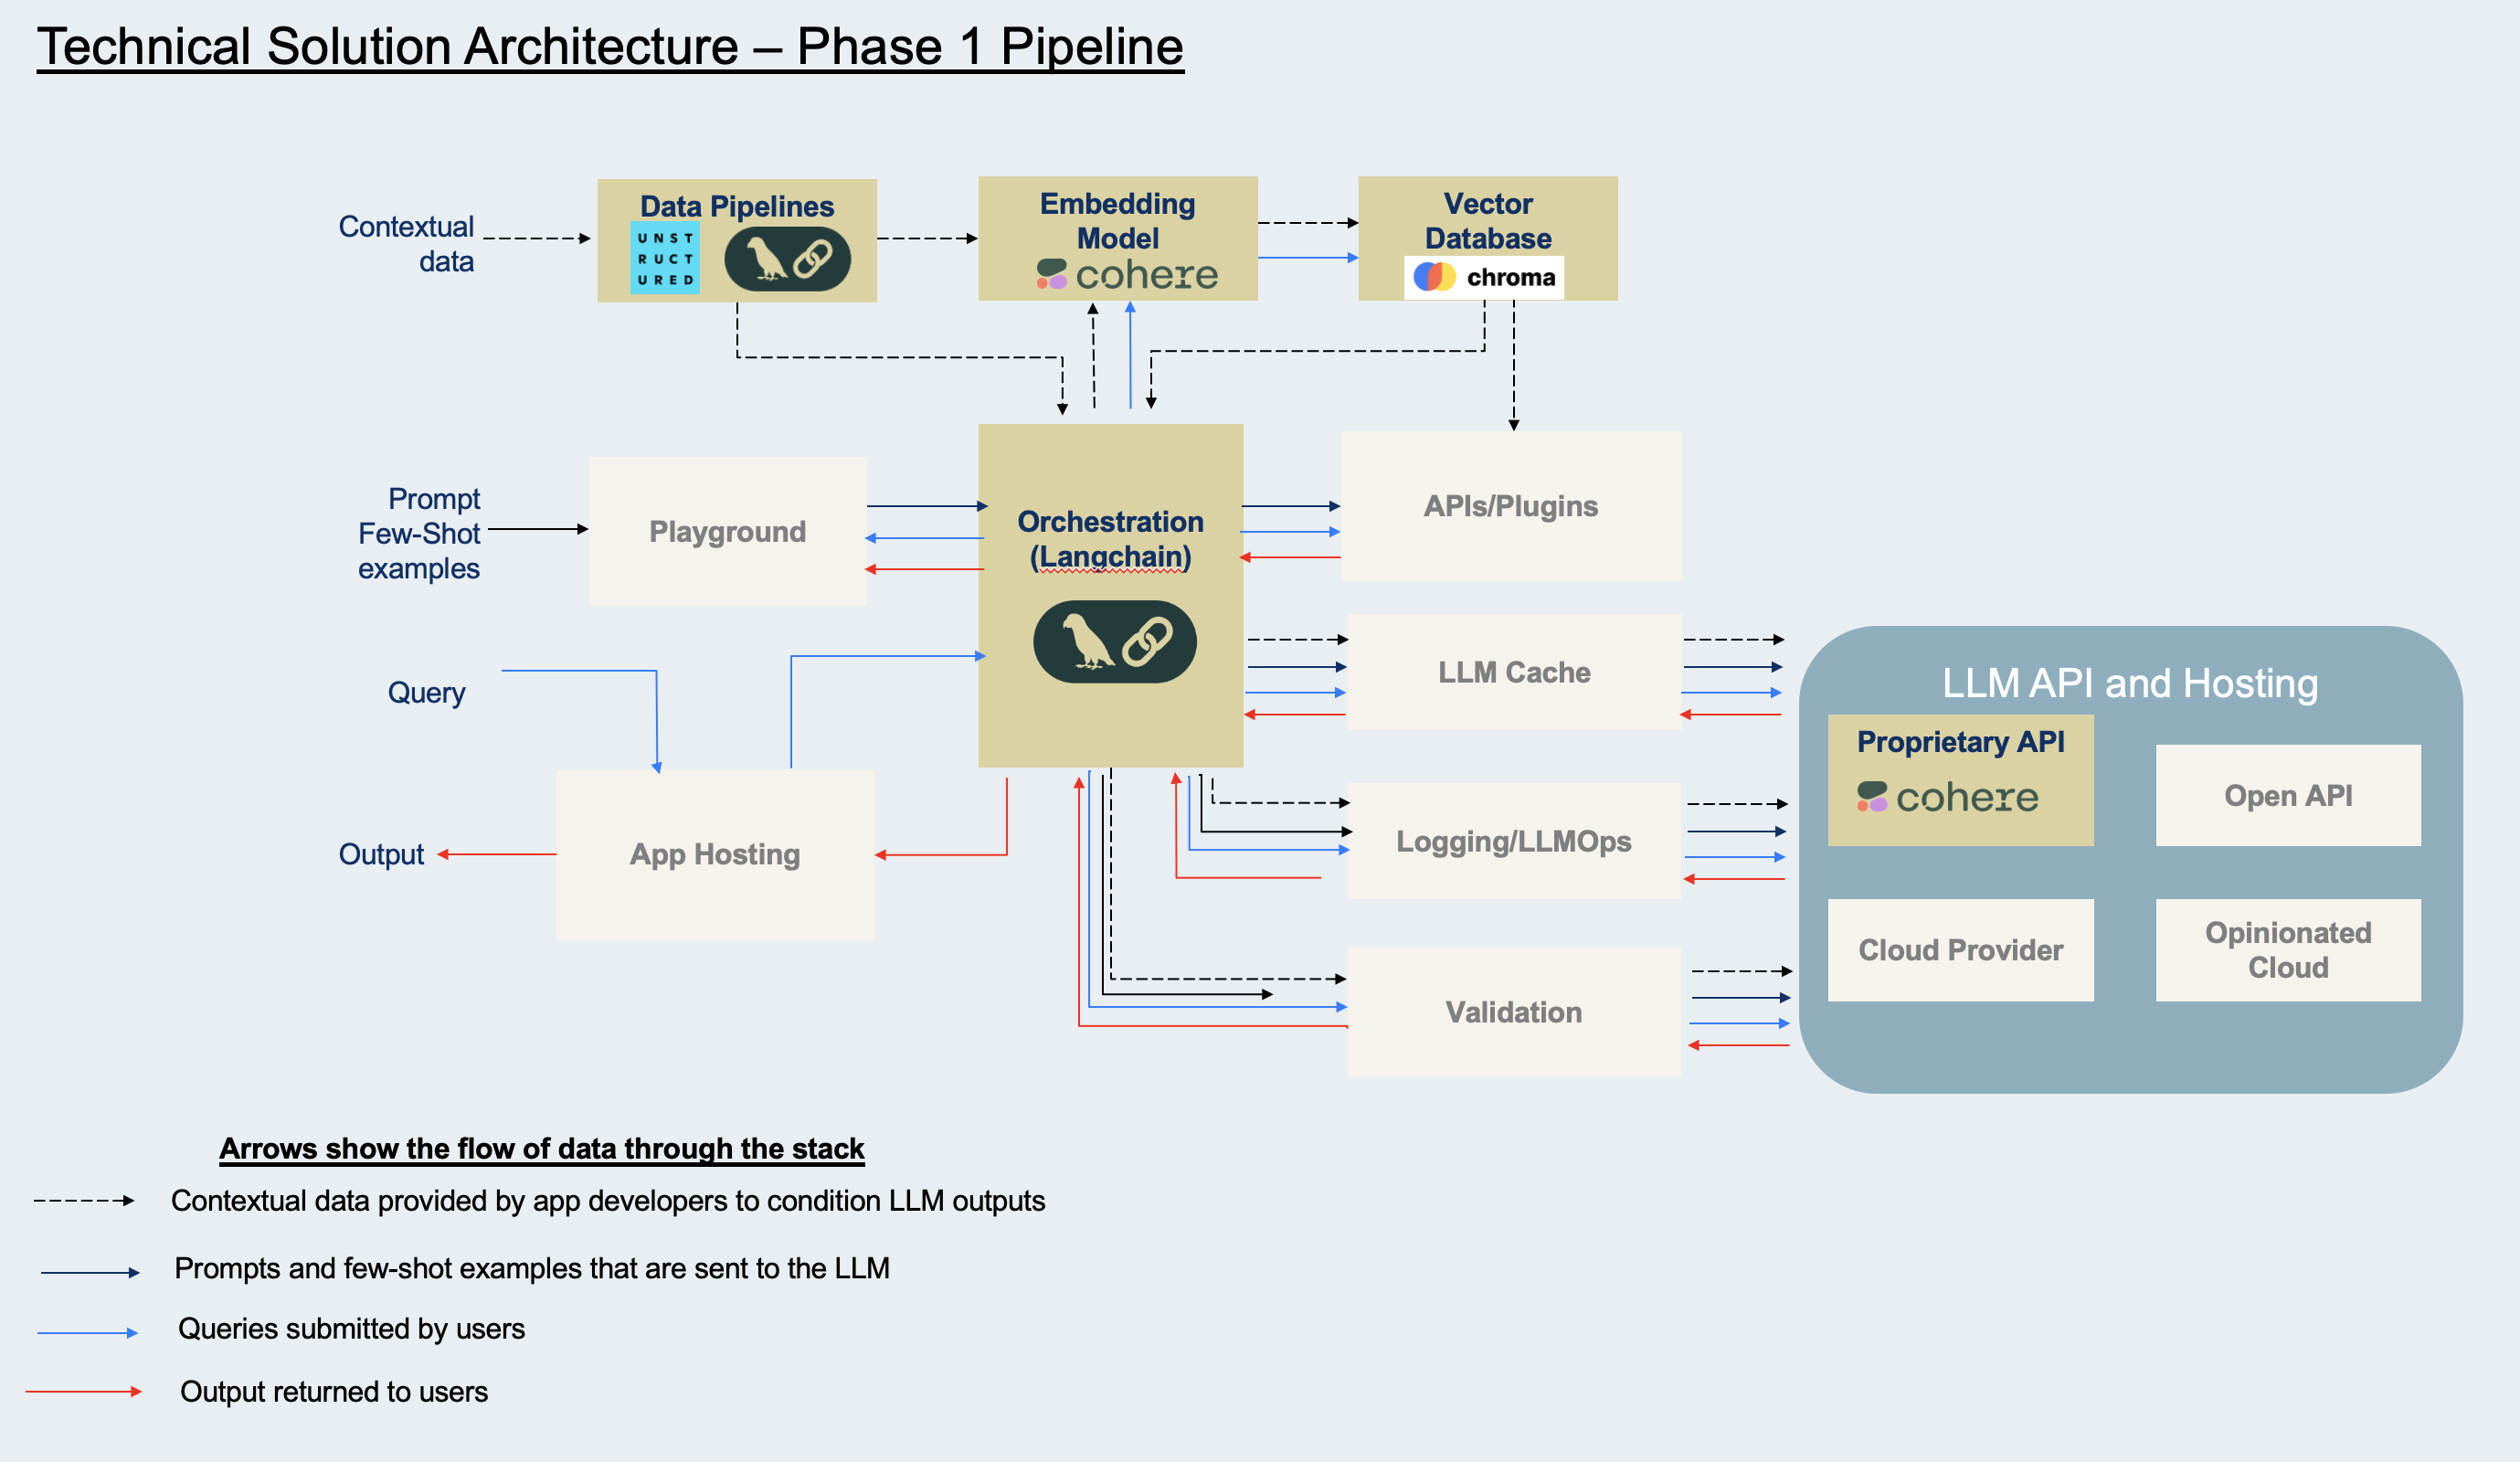

In [1]:
##install necessary libraries
%pip install --quiet langchain langchain_cohere langchain_experimental tiktoken PyMuPDF unstructured

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
import cohere
import langchain
import langchain_core
import langchain_experimental
from dotenv import load_dotenv
load_dotenv()

#create an .env file in the directory including your Cohere API key - .env file should look like:
#COHERE_API_KEY='your API key in here'

COHERE_API_KEY = os.environ.get("COHERE_API_KEY")
co = cohere.Client(COHERE_API_KEY)

# LLM
from langchain_cohere.chat_models import ChatCohere

chat = ChatCohere(model="command-r-plus", temperature=0.3)

In [2]:
# versions
print('cohere version:', cohere.__version__)
print('langchain version:', langchain.__version__)
print('langchain_core version:', langchain_core.__version__)
print('langchain_experimental version:', langchain_experimental.__version__)

cohere version: 5.3.4
langchain version: 0.1.20
langchain_core version: 0.1.52
langchain_experimental version: 0.0.58


## Langchain Directory Loader

We're creating a function create_directory_loader using Langchain's DirectoryLoader to load an entire folder which consists of PDF documents and CSV files
- there needs to be a child folder named data 
- we can add other data types if needed
- we need to update the function 
	1.	Error Handling
	2.	Quality Checks
	3.  How to load marginal data? 

#### Loading a Folder with PDF's and CSV's

In [5]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders.pdf import PyMuPDFLoader
from langchain.document_loaders.csv_loader import CSVLoader


# Define a dictionary to map file extensions to their respective loaders
directory_loaders = {
    '.pdf': PyMuPDFLoader,
    '.csv': CSVLoader,
}

# Define a function to create a DirectoryLoader for a specific file type
def create_directory_loader(file_type, directory_path):
    return DirectoryLoader(
        path=directory_path,
        glob=f"**/*{file_type}",
        loader_cls=directory_loaders[file_type],
    )   

# Create DirectoryLoader instances for each file type
pdf_loader = create_directory_loader('.pdf', '../data')
csv_loader = create_directory_loader('.csv', '../data')

# Load the files
pdf_documents = pdf_loader.load()
csv_documents = csv_loader.load()

#### Loading Websites with URLs 

In [7]:
from langchain_community.document_loaders import UnstructuredURLLoader

urls = [
    "https://www.rbcgam.com/en/ca/learn-plan/investment-strategies/understanding-responsible-investment/detail",
    "https://www.rbcgam.com/en/ca/learn-plan/investment-strategies/an-investors-guide-to-net-zero-emissions/detail",
    "https://www.rbcgam.com/en/ca/learn-plan/investment-strategies/a-guide-to-portfolio-carbon-emissions/detail",
    "https://www.rbcgam.com/en/ca/learn-plan/investment-strategies/what-esg-is-and-isnt/detail",
    "https://www.rbcgam.com/en/ca/learn-plan/investment-strategies?section=theDisciplinedInvestor",
]

url_loader = UnstructuredURLLoader(urls=urls)

url_documents = url_loader.load()

### different document types will be combined into one

In [8]:
# Combine documents
combined_documents = csv_documents  + pdf_documents + url_documents

In [9]:
#### Data Loading the CSV file

WORLD_CSV = pd.read_csv('../data/WORLD_ESG.csv')

In [10]:
WORLD_CSV.head()

,Ticker,Short Name,GICS Sector,GICS Ind Name,Curr Adj Mkt Cap,Mrkt Cap Sum,Weight,EV,ESG Score,UN Glob Comp Sign,...,Cntry Terrtry Of Rsk,Clmt Rsk Phys Lvl,Clmt Rsk Phys Cat,Fossl Fl Op Rev Pct,Oil Op Rev Pct,Coal Op Rev Pct,Tgt Temp Rise Scp 1 And 2 ST,Comp Clm Sci Bse Emiss Targts,Comp Clm Net 0 Emiss Tgt,Invt In Sustain Prods
0,MSFT UW,MICROSOFT CORP,Information Technology,Software,3107149.760,99429445.9,0.0312,3132911.822,5.710000038,Y,...,US,84.0,High Risk,0,0,0,3.2,NaN,Y,NaN
1,AAPL UW,APPLE INC,Information Technology,"Technology Hardware, Storage &",2937550.089,99429445.9,0.0295,2879803.089,6.010000229,NaN,...,US,80.0,High Risk,0,0,0,3.2,Y,Y,NaN
2,NVDA UW,NVIDIA CORP,Information Technology,Semiconductors & Semiconductor,2789467.800,99429445.9,0.0281,2767840.000,6.590000153,NaN,...,US,91.0,High Risk,0,0,0,1.51,Y,NaN,NaN
3,GOOG UW,ALPHABET INC-C,Communication Services,Interactive Media & Services,2144490.495,99429445.9,0.0216,2064401.560,4.230000019,NaN,...,US,97.0,High Risk,0,0,0,3.2,Y,Y,NaN
4,GOOGL UW,ALPHABET INC-A,Communication Services,Interactive Media & Services,2144553.570,99429445.9,0.0216,2064583.075,4.230000019,NaN,...,US,97.0,High Risk,0,0,0,3.2,Y,Y,NaN


#### Chunking and Embedding Storage into Vectorstore (Chroma)

In [11]:
from langchain_cohere import CohereEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

# Split documents
embd = CohereEmbeddings()
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(combined_documents)

# Embed and store in vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embd)
retriever = vectorstore.as_retriever(search_kwargs={"k": 6})

vectorstore_retriever = vectorstore.as_retriever()

#### Create a RAG retriever tool that searches within the vector store

In [12]:
from langchain.tools.retriever import create_retriever_tool

vectorstore_search = create_retriever_tool(
    retriever=vectorstore_retriever,
    name="vectorstore_search",
    description="Retrieve relevant information from a vectorstore that contains documents related to ESG Investing Methods and ESG data for global companies.",
)

#### Create Python interpreter tool

In [16]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

from langchain_core.pydantic_v1 import BaseModel, Field
class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput

#### Create a RAG agent

In [17]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [18]:
# Preamble
preamble = """
You are a data analyst for an ESG investing team. 
Use all tools that are available to answer the question. 

If the query is specific to a company/ticker, sector/industry, or asks about latest ESG data, use the data inside csv files first and then move on to the vectorstore search to find relevant information.

If the query covers overall ESG investing related question, search within the papers and documents in the vectorstore.

Read the following documents and papers:
- Understanding responsible investment
- An investor’s guide to net-zero emissions
- A guide to portfolio carbon emissions
- What is ESG?
- Responsible Investment Strategies
- MSCI Climate VaR methodology part 3: Technology opportunities
- MSCI CLIMATE VAR METHODOLOGY PART 4 – PHYSICAL CLIMATE RISK
- MSCI Climate VaR Methodology Part 1: Overview
- Road to Science-Based Corporate Net-Zero Target Setting 
- Breaking Down Corporate Net-Zero Climate Targets 
- Climate Targets and Commitments Methodology 
- Foundations of Climate Investing: How equity markets have priced climate transition risks
- RBC GAM Climate Dashboard User Guide – Q1 24
- A factor approach to the performance of ESG leaders and laggards (Naffa and Fain, 2022)
- Establishing ESG as Risk Premia (Pollard, Sherwood, and Klobus, 2018)
- Carbon Risk (Gorgen, Jacob,  Nerlinger, Riordan, Rohleder, Wilkins, 2017)
- Carbon tail risk (Ilhan, 2020)
- Do investors care about carbon risks (Bolton and Kacpercyk)
- Kotsantonis et al. (2016):  ESG Integration Myths and Realities
- ‘Re-examining risk premiums in the Fama-French Model: the role of investor sentiment’ Wu et al. (2016)
- Bansal et al.’s (2016) study, “Socially Responsible Investing: Good Is Good, Bad Is Bad”
- Reboredo & Ugolini (2022) Climate transition risk, profitability and stock prices
- Morningstar Sustainability Rating
- Hsu, Li, and Tso. (2022). The Pollution Premium. Journal of Finance, Forthcoming.
- Albuquerque et al. (2019). Corporate Social Responsibility and Firm Risk: Theory and Empirical Evidence. Forthcoming in Management Science, DOI/10.1287/mnsc.2018.3043, WBS Finance Group Research Paper No. 259.
- Reboredo and Ugolini. (2022). Climate Transition Risk, Profitability and Stock Prices. International Review of Financial Analysis, Vol. 83, No. 102271, 2022.
- Ramelli et al. (2019). Stock Price Rewards to Climate Saints and Sinners: Evidence from the Trump Election. NBER Working Paper No. 25310.

You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `../data/WORLD_ESG.csv`.
Here is a preview of the dataframe:
{head_df}
""".format(head_df=WORLD_CSV.head(3).to_markdown())


In [19]:
# Prompt
prompt = ChatPromptTemplate.from_template("{input}")

# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[vectorstore_search, repl_tool],
    prompt=prompt,
)

agent_executor = AgentExecutor(
    agent=agent, tools=[vectorstore_search, repl_tool], verbose=True
)

#### Test input and output

In [20]:
input_text = "What sectors are the largest contributors to carbon emissions?"
result = agent_executor.invoke(
    {
        "input": input_text,
        "preamble": preamble,
    }
)

print(result)



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.



I will use the data in the WORLD_ESG.csv file to find the sectors that are the largest contributors to carbon emissions.
{'tool_name': 'python_interpreter', 'parameters': {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'../data/WORLD_ESG.csv\')\n\n# Calculate total GHG emissions for each sector\ntotal_ghg_emissions = df.groupby(\'GICS Sector\')[\'GHG Scp 1 Est\'].sum()\n\n# Sort the sectors by total GHG emissions in descending order\ntotal_ghg_emissions = total_ghg_emissions.sort_values(ascending=False)\n\nprint("Sectors with the highest total GHG emissions:")\nprint(total_ghg_emissions)'}}
Sectors with the highest total GHG emissions:
GICS Sector
Utilities                 2938507.419
Materials                 2489169.638
Energy                    2209855.403
Industrials                951959.002
Health Care                162606.326
Consumer Staples           146961.696
Financials                 127576.311
Consumer Discretionary     120917.973
Information Technology      41699.08

In [21]:
input_text = "What is the framework for attributing changes in portfolio carbon footprint?"
result = agent_executor.invoke(
    {
        "input": input_text,
        "preamble": preamble,
    }
)

print(result)



> Entering new AgentExecutor chain...

I will search for the framework for attributing changes in portfolio carbon footprint in the provided documents.
{'tool_name': 'vectorstore_search', 'parameters': {'query': 'framework for attributing changes in portfolio carbon footprint'}}
A Framework for Attributing 
Changes in Portfolio Carbon 
Footprint
Zoltán Nagy, Guido Giese, and Xinxin Wang
KEY FINDINGS
n	 While tracking portfolios’ carbon footprint is a key requirement for setting and tracking
net-zero targets, it is challenging in practice because changes in carbon footprints may
be driven by changes in climate-related variables, portfolio rebalancing, or financial
variables.
n	 A framework is proposed that attributes changes in portfolio-level emissions to their
primary drivers, including changes in the portfolio composition, changes in issuers’
emissions, as well as changes in ownership and financing structure.
n	 The framework proposed allows investors to understand to what extent c